# ◆Forex forecast USD／JPY
### 目的：為替予測
### 米ドル円の日足をもとに、翌日の終値が上昇するか下落するか予測を行う。
- kaggle URL:https://stooq.com/q/d/?s=usdjpy&c=0
- Create Date：2020/01/15　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込

### 2.データ前処理

### 3.モデル構築
- 各アルゴリズムのハイパーパラメータ探索を行う。（ロジスティック回帰）

### 4.モデル評価
- 最良のモデルで汎化性能を算出する。
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「usdjpy_d.csv」

| 列 | 項目 | 項目名 | 欠損有無 | 利用概要 |
|:---:|:---:|:---:|:---:|:---:|
|  1 | Date| 日付 | - | ○ |
|  2 | Open |始値 | - | ○ |
|  3 | High |高値 | - | ○ |
|  4 | Low |底値 | - | ○ |
|  5 | Close |終値 | - | ○ |

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from time                    import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.linear_model    import SGDClassifier
from sklearn.svm             import SVC
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from matplotlib import ticker
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import matplotlib.dates as mdates
import mpl_finance as mpf
import codecs as cd
import warnings
import mpl_finance
warnings.filterwarnings('ignore')

# ****************************************************************************
# 設定値
# ****************************************************************************
train_size = 0.80

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 30)
    
# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))

# ============================================================================
# 学習曲線を作成
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(12,5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# ============================================================================
# 関数：傾きを算出
# ============================================================================
def get_tilt(close):
    
    length = len(close)
    tilt = np.zeros(length)
    
    for i in range(length):
        if i < 1:
            tilt[i] = 0
        else :
            a = pd.Series(close)[i:i+1].values - pd.Series(close)[i-1:i].values
            tilt[i] = a/1
    return tilt

# ============================================================================
# 関数：get_rsi
# ============================================================================
def get_rsi(close, period):
    
    diff = close.diff()
    # 値上がり幅、値下がり幅をシリーズへ切り分け
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    # 値上がり幅/値下がり幅の単純移動平均（period)を処理
    up_sma = up.rolling(window=period, center=False).mean()
    down_sma = down.abs().rolling(window=period, center=False).mean()
    
    # RSIの計算
    rs = up_sma / down_sma
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

# ============================================================================
# 関数：get_rci
# ============================================================================
def get_rci(close, period):
    
    rank_period = np.arange(period, 0, -1)
    length = len(close)
    rci = np.zeros(length)
    
    for i in range(length):
        if i < period - 1:
            rci[i] = 0
        else :
            #価格順位取得             
            rank_price = pd.Series(close)[i - period + 1: i + 1].rank(method='min', ascending = False).values
            #rciを取得(int型で取得)
            rci[i] = np.int32((1 - (6 * sum((rank_period - rank_price)**2)) / (period**3 - period)) * 100)
            
    return rci

# ============================================================================
# 関数：get_bb
# ============================================================================
def get_bb(close, sigma):
    
    # ±１σの中での値動きになる確率は68.3%
    # ±2σの中での値動きになる確率は95.5%
    mean = close.rolling(window=21).mean()
    std = close.rolling(window=21).std()
    upper = mean + (std * sigma)
    lower = mean - (std * sigma)

    return upper,lower

# ============================================================================
# 関数：get_momentum
# ============================================================================
def get_momentum(close, period):
    # モメンタム＝当日の終値−（period前の終値）
    return close - close.shift(period)

# ============================================================================
# 関数：get_sma
# ============================================================================
def get_sma(close, period):
    return list(pd.Series(close).rolling(period).mean())

# ============================================================================
# 関数：get_ema
# ============================================================================
def get_ema(close, period):
    return list(pd.Series(close).ewm(span=period).mean())

# 1.データ読込

In [2]:
df= pd.read_csv('./input/usdjpy_d.csv',parse_dates=['Date'])

# column name change
df.rename(columns={'Date' : 'time'}, inplace=True)
df.rename(columns={'Open' : 'open'}, inplace=True)
df.rename(columns={'High' : 'high'}, inplace=True)
df.rename(columns={'Low' : 'low'}, inplace=True)
df.rename(columns={'Close' : 'close'}, inplace=True)

# calc target
df = df.query('time >= "2016-01-01"')

# ---------------------------------------------------------

# sma/ema
df['sma5']= get_sma(df.close,5)
df['sma21']= get_sma(df.close,21)
df['ema10']= get_ema(df.close,10)

# tilt(sma/ema)
df['tilt_sma5']= get_tilt(df.sma5)
df['tilt_sma21']= get_tilt(df.sma21)
df['tilt_ema10']= get_tilt(df.ema10)

# ボリンジャーバンド2σ
df['bb2_up'], df['bb2_low'] = get_bb(df.close, 2)

# モメンタム
df['momentum_5'] = get_momentum(df.close, 5)
df['momentum_10'] = get_momentum(df.close, 10)
df['momentum_21'] = get_momentum(df.close, 21)

# RCI
df['rci9'] = get_rci(df.close,9)
df['rci21'] = get_rci(df.close,21)
df['rci52'] = get_rci(df.close,52)

# tilt(RCI)
df['tilt_rci9'] = get_tilt(df.rci9)
df['tilt_rci21'] = get_tilt(df.rci21)
df['tilt_rci52'] = get_tilt(df.rci52)

# RSI
df['rsi14'] = get_rsi(df.close,14)
df['tilt_rsi14'] = get_tilt(df.rsi14)

# ---------------------------------------------------------

# ローソク足の特徴量
df['day_chg'] = df.close - df.open # 一日の変化量
df['c_up'] = np.where(df.day_chg >= 0,1,0) # 陽線：1／陰線：0
df['c_all_len'] = abs(df.high - df.low) # ローソクの長さ(ヒゲ含む)
df['c_pil_len'] = np.where(df.day_chg >= 0,df.close - df.open,df.open - df.close) # ローソクの長さ
df['top_bar'] = np.where(df.day_chg >= 0,df.high - df.close, df.high - df.open) # 上ヒゲの長さ
df['low_bar'] = np.where(df.day_chg >= 0,df.open - df.low, df.close - df.low)   # 下ヒゲの長さ

# https://east-fx.com/archives/553
dic_c = {'c_y_b':'陽の丸坊主',
         'c_y_dai':'大陽線',
         'c_y_h_b':'陽の大引け坊主',
         'c_y_y_b':'陽の寄り付き坊主',
         'c_y_sg':'下影陽線',
         'c_y_ug':'上影陽線',
         'c_y_km':'陽のコマ',
         'c_y_kk':'陽のカラカサ',
         'c_i_b':'陰の丸坊主',
         'c_i_dai':'大陰線',
         'c_i_y_b':'陰の寄り付き坊主',
         'c_i_h_i':'陰の大引け陰線',
         'c_i_sg':'下影陰線',
         'c_i_km':'陰のコマ',
         'c_i_ug':'上影陰線',
         'c_i_kk':'陰のカラカサ',
         'c_juji':'十字',
         'c_tonbo':'トンボ',
         'c_touba':'トウバ',
         'c_ippon':'一本線'
         }

# 陽の丸坊主(ヒゲがなく実体が長い陽線。買い勢力がかなり強い形)
df['c_y_b'] = np.where((df.c_up == 1) & (df.top_bar < 0.05) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 大陽線(上下ヒゲはあるが実体が長い陽線。買い勢力がかなり強い形。)
df['c_y_dai'] = np.where((df.c_up == 1) & (df.top_bar >= 0.05) & (df.low_bar >= 0.05) & (df.c_pil_len >= 0.6), 1 , 0)
# 陽の大引け坊主(上ヒゲがなく、下ヒゲがある。買いの勢いがまだまだ強い形。)
df['c_y_h_b'] = np.where((df.c_up == 1) & (df.top_bar < 0.05) & (df.low_bar >= 0.10) & (df.c_pil_len >= 0.4), 1 , 0)
# 陽の寄り付き坊主(上ヒゲのみの陽線。買い勢力が強いが、上ヒゲが長すぎると天井になる可能性もある形。)
df['c_y_y_b'] = np.where((df.c_up == 1) & (df.top_bar >= 0.10) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 下影陽線(実体よりも下ヒゲが長い形。一旦売り勢力に攻め込まれてからの戻しの長いヒゲなので、買い勢力が強い。)
df['c_y_sg'] = np.where((df.c_up == 1) & (df.low_bar >= 0.40) & (df.low_bar > df.c_pil_len), 1 , 0)
# 上影陽線(実体よりも上ヒゲが長い形。買い勢力が売り勢力に押され気味になり上ヒゲになるので、買い勢力が若干弱め。実体が短すぎ場合はトレンド転換の可能性あり。)
df['c_y_ug'] = np.where((df.c_up == 1) & (df.top_bar >= 0.40) & (df.top_bar > df.c_pil_len), 1 , 0)
# 陽のコマ(保ち合い。売り買いの勢力が拮抗している状態で現れる。陽線の場合は強持ち合いと呼ばれる。トレンド転換の可能性あり。)
df['c_y_km'] = np.where((df.c_up == 1) & (df.top_bar < 0.10) & (df.low_bar < 0.10) & (df.c_pil_len < 0.20), 1 , 0)
# 陽のカラカサ(下ヒゲが長く、実体がヒゲよりも小さい形。トレンド転換する可能性あり。)
df['c_y_kk'] = np.where((df.c_up == 1) & (df.low_bar >= 0.40) & (df.top_bar < 0.05) & (df.c_pil_len < df.low_bar), 1 , 0)

# 陰の丸坊主(ヒゲがなく実体が長い陰線。売り勢力がかなり強い形)
df['c_i_b'] = np.where((df.c_up == 0) & (df.top_bar < 0.05) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 大陰線(上下ヒゲはあるが実体が長い陰線。売り勢力がかなり強い形。)
df['c_i_dai'] = np.where((df.c_up == 0) & (df.top_bar >= 0.05) & (df.low_bar >= 0.05) & (df.c_pil_len >= 0.6), 1 , 0)
# 陰の寄り付き坊主(上ヒゲがない陰線。実体部分が長いので売り勢力優勢ではあるが、下ヒゲが長すぎるとトレンド転換の可能性あり。)
df['c_i_y_b'] = np.where((df.c_up == 0) & (df.top_bar < 0.05) & (df.low_bar >= 0.10) & (df.c_pil_len >= 0.4), 1 , 0)
# 陰の大引け陰線(下ヒゲがない形。実体部分が長く売り勢力の勢いも強い。)
df['c_i_h_i'] = np.where((df.c_up == 0) & (df.top_bar >= 0.10) & (df.low_bar < 0.05) & (df.c_pil_len >= 0.4), 1 , 0)
# 下影陰線(下ヒゲが長く実体がヒゲよりも短い陰線。売りの勢力が少し弱まっている際に出現しやすいので、トレンド転換する可能性あり。)
df['c_i_sg'] = np.where((df.c_up == 0) & (df.low_bar >= 0.40) & (df.low_bar > df.c_pil_len), 1 , 0)
# 陰のコマ(売り・買い勢力が拮抗している形。陰線の場合は弱持合いと呼ばれている。)
df['c_i_km'] = np.where((df.c_up == 0) & (df.top_bar < 0.10) & (df.low_bar < 0.10) & (df.c_pil_len < 0.2), 1 , 0)
# 上影陰線(上ヒゲが長く実体がヒゲより短い形。一旦買い勢力に押し戻されてから再度ヒゲをつけて戻しているので、売り勢力が強い。ただ、実体が短すぎるとトレンド転換の可能性もある。)
df['c_i_ug'] = np.where((df.c_up == 0) & (df.top_bar >= 0.40) & (df.top_bar > df.c_pil_len), 1 , 0)
# 陰のカラカサ(下ヒゲが長く上ヒゲがなく、且つ実体が短い形。)
df['c_i_kk'] = np.where((df.c_up == 0) & (df.low_bar >= 0.40) & (df.top_bar < 0.05) & (df.c_pil_len < df.low_bar), 1 , 0)

# 十字（天井もしくは底ならトレンド転換の可能性あり。）
df['c_juji'] = np.where((df.c_pil_len < 0.1) & (abs(df.top_bar - df.low_bar) <= 0.1) & (df.c_pil_len < 0.1), 1 , 0)
# トンボ（天井もしくは底ならトレンド転換の可能性あり。）
df['c_tonbo'] = np.where((df.top_bar < 0.05) & (df.low_bar >= 0.2) & (df.c_pil_len < 0.1), 1 , 0)
# トウバ(天井もしくは底ならトレンド転換の可能性あり。)
df['c_touba'] = np.where((df.low_bar < 0.05) & (df.top_bar >= 0.2) & (df.c_pil_len < 0.1), 1 , 0)
# 一本線(継続トレンド転換の可能性あり)
df['c_ippon'] = np.where((df.low_bar < 0.05) & (df.top_bar < 0.05) & (df.c_pil_len < 0.1), 1 , 0)

# 直近数日間のローソク足の特徴量
df['y1_day_chg'] = df.day_chg.shift(+1)
df['y1_c_all_len'] = df.c_all_len.shift(+1)
df['y1_c_pil_len'] = df.c_pil_len.shift(+1)
df['y1_c_up'] = df.c_up.shift(+1)
df['y1_top_bar'] = df.top_bar.shift(+1)
df['y1_low_bar'] = df.low_bar.shift(+1)

df['y2_day_chg'] = df.day_chg.shift(+2)
df['y2_c_all_len'] = df.c_all_len.shift(+2)
df['y2_c_pil_len'] = df.c_pil_len.shift(+2)
df['y2_c_up'] = df.c_up.shift(+2)
df['y2_top_bar'] = df.top_bar.shift(+2)
df['y2_low_bar'] = df.low_bar.shift(+2)

df['y3_day_chg'] = df.day_chg.shift(+3)
df['y3_c_all_len'] = df.c_all_len.shift(+3)
df['y3_c_pil_len'] = df.c_pil_len.shift(+3)
df['y3_c_up'] = df.c_up.shift(+3)
df['y3_top_bar'] = df.top_bar.shift(+3)
df['y3_low_bar'] = df.low_bar.shift(+3)

df['y4_day_chg'] = df.day_chg.shift(+4)
df['y4_c_all_len'] = df.c_all_len.shift(+4)
df['y4_c_pil_len'] = df.c_pil_len.shift(+4)
df['y4_c_up'] = df.c_up.shift(+4)
df['y4_top_bar'] = df.top_bar.shift(+4)
df['y4_low_bar'] = df.low_bar.shift(+4)

df['y5_day_chg'] = df.day_chg.shift(+5)
df['y5_c_all_len'] = df.c_all_len.shift(+5)
df['y5_c_pil_len'] = df.c_pil_len.shift(+5)
df['y5_c_up'] = df.c_up.shift(+5)
df['y5_top_bar'] = df.top_bar.shift(+5)
df['y5_low_bar'] = df.low_bar.shift(+5)

df['ren2_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1), 1 , 0)
df['ren3_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1), 1 , 0)
df['ren4_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1), 1 , 0)
df['ren5_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1) & (df.y4_c_up == 1), 1 , 0)
df['ren6_up'] = np.where((df.c_up == 1) & (df.y1_c_up == 1) & (df.y2_c_up == 1) & (df.y3_c_up == 1) & (df.y4_c_up == 1) & (df.y5_c_up == 1), 1 , 0)

df['ren2_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0), 1 , 0)
df['ren3_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0), 1 , 0)
df['ren4_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0), 1 , 0)
df['ren5_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0) & (df.y4_c_up == 0), 1 , 0)
df['ren6_down'] = np.where((df.c_up == 0) & (df.y1_c_up == 0) & (df.y2_c_up == 0) & (df.y3_c_up == 0) & (df.y4_c_up == 0) & (df.y5_c_up == 0), 1 , 0)

# test target
df = df.query('time >= "2017-01-01"')

printmd('▼ size')
display(df.shape)

printmd('▼ 直近5行表示')
display(df.tail(10))



**▼ size**

(791, 90)



**▼ 直近5行表示**

,time,open,high,low,close,sma5,sma21,ema10,tilt_sma5,tilt_sma21,tilt_ema10,bb2_up,bb2_low,momentum_5,momentum_10,momentum_21,rci9,rci21,rci52,tilt_rci9,tilt_rci21,tilt_rci52,rsi14,tilt_rsi14,day_chg,c_up,c_all_len,c_pil_len,top_bar,low_bar,c_y_b,c_y_dai,c_y_h_b,c_y_y_b,c_y_sg,c_y_ug,c_y_km,c_y_kk,c_i_b,c_i_dai,c_i_y_b,c_i_h_i,c_i_sg,c_i_km,c_i_ug,c_i_kk,c_juji,c_tonbo,c_touba,c_ippon,y1_day_chg,y1_c_all_len,y1_c_pil_len,y1_c_up,y1_top_bar,y1_low_bar,y2_day_chg,y2_c_all_len,y2_c_pil_len,y2_c_up,y2_top_bar,y2_low_bar,y3_day_chg,y3_c_all_len,y3_c_pil_len,y3_c_up,y3_top_bar,y3_low_bar,y4_day_chg,y4_c_all_len,y4_c_pil_len,y4_c_up,y4_top_bar,y4_low_bar,y5_day_chg,y5_c_all_len,y5_c_pil_len,y5_c_up,y5_top_bar,y5_low_bar,ren2_up,ren3_up,ren4_up,ren5_up,ren6_up,ren2_down,ren3_down,ren4_down,ren5_down,ren6_down
12535,2020-01-09,109.078,109.582,109.013,109.480,108.6990,109.098429,108.918809,0.1862,0.043000,0.124709,110.065865,108.130992,0.931,0.102,0.903,1.0,-36.0,19.0,59.0,-1.0,3.0,48.631518,5.596375,0.402,1,0.569,0.402,0.102,0.065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,-0.137,0.651,0.137,0.0,0.179,0.335,1,1,1,0,0,0,0,0,0,0
12536,2020-01-10,109.478,109.688,109.437,109.500,108.9788,109.131762,109.024480,0.2798,0.033333,0.105671,110.104236,108.159288,1.399,-0.076,0.700,48.0,-33.0,24.0,47.0,3.0,5.0,51.757576,3.126057,0.022,1,0.251,0.022,0.188,0.041,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,-0.446,0.780,0.446,0.0,0.084,0.250,1,1,1,1,0,0,0,0,0,0
12537,2020-01-13,109.538,109.947,109.534,109.934,109.2900,109.197762,109.189847,0.3112,0.066000,0.165367,110.191730,108.203794,1.556,0.500,1.386,73.0,-27.0,28.0,25.0,6.0,4.0,56.058515,4.300939,0.396,1,0.413,0.396,0.013,0.004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,0.572,0.731,0.572,1.0,0.127,0.032,1,1,1,1,1,0,0,0,0,0
12538,2020-01-14,109.935,110.200,109.862,109.988,109.5960,109.221571,109.334966,0.3060,0.023810,0.145119,110.267343,108.175799,1.530,1.110,0.500,90.0,-8.0,32.0,17.0,19.0,4.0,58.191460,2.132945,0.053,1,0.338,0.053,0.212,0.073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0.080,0.365,0.080,1.0,0.170,0.115,1,1,1,1,1,0,0,0,0,0
12539,2020-01-15,109.987,110.001,109.790,109.887,109.7578,109.247952,109.435336,0.1618,0.026381,0.100370,110.332753,108.163152,0.809,1.283,0.554,95.0,2.0,32.0,5.0,10.0,0.0,56.951653,-1.239807,-0.100,0,0.211,0.100,0.014,0.097,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0.619,1.593,0.619,1.0,0.166,0.808,0,0,0,0,0,0,0,0,0,0
12540,2020-01-16,109.887,110.186,109.856,110.178,109.8974,109.274762,109.570366,0.1396,0.026810,0.135030,110.423599,108.125925,0.698,1.629,0.563,95.0,22.0,33.0,0.0,20.0,1.0,58.018114,1.066461,0.291,1,0.330,0.291,0.008,0.031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.100,0.211,0.100,0.0,0.014,0.097,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0.402,0.569,0.402,1.0,0.102,0.065,0,0,0,0,0,0,0,0,0,0
12541,2020-01-17,110.178,110.291,110.051,110.149,110.0272,109.305000,109.675572,0.1298,0.030238,0.105206,110.512227,108.097773,0.649,2.048,0.635,93.0,39.0,35.0,-2.0,17.0,2.0,59.818731,1.800617,-0.029,0,0.240,0.029,0.113,0.098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.291,0.330,0.291,1.0,0.008,0.031,-0.100,0.211,0.100,0.0,0.014,0.097,0.053,0.338,0.053,1.0,0.212,0.073,0.396,0.413,0.396,1.0,0.013,0.004,0.022,0.251,0.022,1.0,0.188,0.041,0,0,0,0,0,0,0,0,0

In [3]:
# ローソク足の形データチェック
for k,v in dic_c.items():
    printmd('▼' + str(k) + ':' + str(v))
    print(df[k].value_counts())
    #tmp_df = df.query(k + '== 1').head(10)
    #display(tmp_df[['time','open','high','low','close']])



**▼c_y_b:陽の丸坊主**

0    779
1     12
Name: c_y_b, dtype: int64




**▼c_y_dai:大陽線**

0    751
1     40
Name: c_y_dai, dtype: int64




**▼c_y_h_b:陽の大引け坊主**

0    780
1     11
Name: c_y_h_b, dtype: int64




**▼c_y_y_b:陽の寄り付き坊主**

0    771
1     20
Name: c_y_y_b, dtype: int64




**▼c_y_sg:下影陽線**

0    766
1     25
Name: c_y_sg, dtype: int64




**▼c_y_ug:上影陽線**

0    776
1     15
Name: c_y_ug, dtype: int64




**▼c_y_km:陽のコマ**

0    785
1      6
Name: c_y_km, dtype: int64




**▼c_y_kk:陽のカラカサ**

0    787
1      4
Name: c_y_kk, dtype: int64




**▼c_i_b:陰の丸坊主**

0    786
1      5
Name: c_i_b, dtype: int64




**▼c_i_dai:大陰線**

0    749
1     42
Name: c_i_dai, dtype: int64




**▼c_i_y_b:陰の寄り付き坊主**

0    756
1     35
Name: c_i_y_b, dtype: int64




**▼c_i_h_i:陰の大引け陰線**

0    777
1     14
Name: c_i_h_i, dtype: int64




**▼c_i_sg:下影陰線**

0    760
1     31
Name: c_i_sg, dtype: int64




**▼c_i_km:陰のコマ**

0    779
1     12
Name: c_i_km, dtype: int64




**▼c_i_ug:上影陰線**

0    766
1     25
Name: c_i_ug, dtype: int64




**▼c_i_kk:陰のカラカサ**

0    781
1     10
Name: c_i_kk, dtype: int64




**▼c_juji:十字**

0    719
1     72
Name: c_juji, dtype: int64




**▼c_tonbo:トンボ**

0    783
1      8
Name: c_tonbo, dtype: int64




**▼c_touba:トウバ**

0    786
1      5
Name: c_touba, dtype: int64




**▼c_ippon:一本線**

0    789
1      2
Name: c_ippon, dtype: int64


# 2. データ可視化

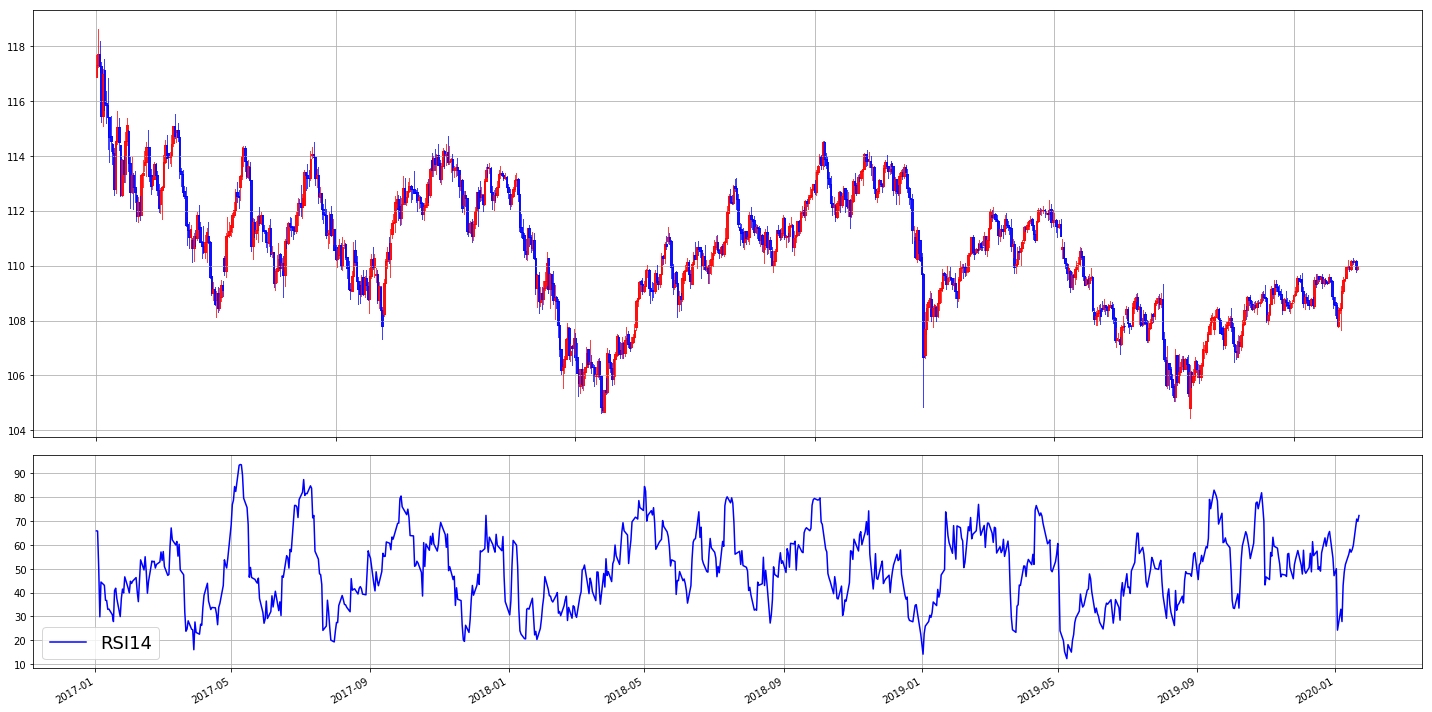

In [4]:
plt.rcParams['figure.figsize'] = [20.0, 10.0]
plt.rc('figure.subplot', left=0.5, right=0.9, bottom=0.1, top=0.9)
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4, 2]})

# --------------------------------------------------------------------------
# ローソク足
mpl_finance.candlestick2_ohlc(ax1,opens=df.open, highs=df.high, lows=df.low, closes=df.close, 
                              width=1,colorup='r', colordown='b')

# x軸を時間にする
xdate = df.index
ax1.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax1.grid(b=True, which='major', axis='both') #グリッド表示
def mydate(x, pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))
ax1.format_xdata = mdates.DateFormatter('%Y-%m-%d')

fig.autofmt_xdate()
fig.tight_layout()

# --------------------------------------------------------------------------
# テクニカルチャート
ax2.plot(df.time, df.rsi14, color='b', antialiased=True, label='RSI14')
ax2.grid(b=True, which='major', axis='both') #グリッド表示

# --------------------------------------------------------------------------

plt.legend(loc='lower left',fontsize=18)
fig.tight_layout()
plt.show()

### 翌日終値が当日終値よりも上昇するかを予測する

In [5]:
# 翌日終値が当日終値よりも上昇するかを予測
df['t1_close'] = df.close.shift(-1)
df['t1_diff'] = df['t1_close'] - df['close']

# 30pips 上昇したら1、30pips下落したら2、それ以外は0
#df['target'] = np.where(df['diff'] >= 0.3,1,np.where(df['diff'] < -0.3,2, 0))
# 5pips 上昇したら1、それ以外は0
df['target'] = np.where(df['t1_diff'] >= 0.01,1,0)



**▼ 目的変数 targetの種類（%）**

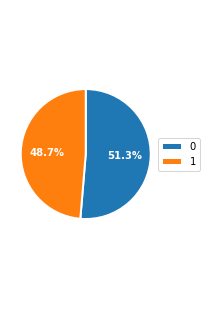

,target
0,406
1,385


In [6]:
printmd('▼ 目的変数 targetの種類（%）')
per_state = round(df['target'].value_counts() / len(df['target']) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

display(pd.DataFrame(df['target'].value_counts(),columns=['target']))

In [7]:
# データセットの行数、列数を取得
split_row = np.int(train_size * df.shape[0])
end_row = df.shape[0]

# 翌日の予測用を保持
X_today_df = df.tail(1)

X_all_df = df.drop(['time','t1_close','t1_diff','target'], axis=1)

# 標準化項目リスト
enc_norm_col = ['open','high','low','close',
                'sma5','sma21','ema10',
                'rci9','rci21','rci52',
                'tilt_rci9','tilt_rci21','tilt_rci52',
                'tilt_sma5','tilt_sma21',
                'tilt_ema10',
                'rsi14',
                'tilt_rsi14',
                'bb2_up','bb2_low',
                'momentum_5','momentum_10','momentum_21',
                'day_chg','c_all_len','c_pil_len','top_bar','low_bar',
                'y1_day_chg','y1_c_all_len','y1_c_pil_len','y1_top_bar','y1_low_bar',
                'y2_day_chg','y2_c_all_len','y2_c_pil_len','y2_top_bar','y2_low_bar',
                'y3_day_chg','y3_c_all_len','y3_c_pil_len','y3_top_bar','y3_low_bar',
                'y4_day_chg','y4_c_all_len','y4_c_pil_len','y4_top_bar','y4_low_bar',
                'y5_day_chg','y5_c_all_len','y5_c_pil_len','y5_top_bar','y5_low_bar',
               ]

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, X_all_df.columns.get_loc(col_name))
X_columns = X_all_df.columns

# -------------------------------------------------
# ndarrayに変換
X_all = X_all_df.values
y_all = df['target'].values

# 訓練用
X_train = X_all[:split_row, :]
y_train = y_all[:split_row]

# テスト用
X_test = X_all[split_row+1:end_row-1,:]
y_test = y_all[split_row+1:end_row-1]

# 翌日の予測用
X_today = X_all[end_row - 1:,:]

# 標準化
for col_name,col_idx in dic_norm_col.items():
    
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    X_today[:,col_idx:col_idx+1] = stdsc.transform(X_today[:,col_idx:col_idx+1])
    

# モデル構築

Score: 0.526899 (0.019874) with: {'alpha': 0.0001, 'penalty': 'none'}
----------------------------------------------
Score: 0.553797 (0.045870) with: {'alpha': 0.0001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.523734 (0.041265) with: {'alpha': 0.0001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.531646 (0.020201) with: {'alpha': 0.0001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.520570 (0.023830) with: {'alpha': 0.001, 'penalty': 'none'}
----------------------------------------------
Score: 0.555380 (0.030168) with: {'alpha': 0.001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.512658 (0.017889) with: {'alpha': 0.001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.552215 (0.024971) with: {'alpha': 0.001, 'penalty': 'elasticnet'}
----------------------------------------------
★BestScore: 0.555380 using {'alpha': 0.001, 'penalty': 'l1'}


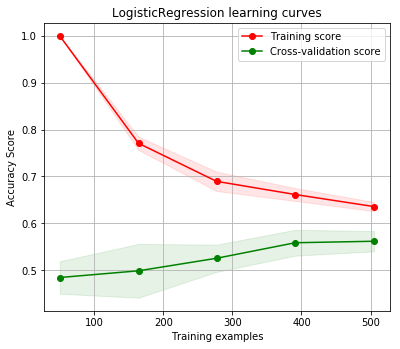

In [8]:
dic_models = {} # アルゴリズムごとに結果を格納
kfold = KFold(n_splits=5, random_state=1234)

# ロジスティック回帰
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
grid = GridSearchCV(estimator=lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
dic_models.setdefault('LogisticRegression', grid_result) # 辞書に格納
best_lr = grid_result.best_estimator_
# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)

# 学習



**▼ 重みを表示（絶対値の降順：Top10）**

,feature,weight
0,c_y_h_b,-3.661735
1,c_y_km,-3.303991
2,c_i_kk,-2.745347
3,c_tonbo,-1.633591
4,y2_day_chg,-1.357840
5,ren5_up,1.244188
6,y4_day_chg,-1.207013
7,tilt_sma5,1.182325
8,momentum_5,1.182325
9,c_y_b,-1.100605




**▼ 重みの大きさを横棒グラフで表示**

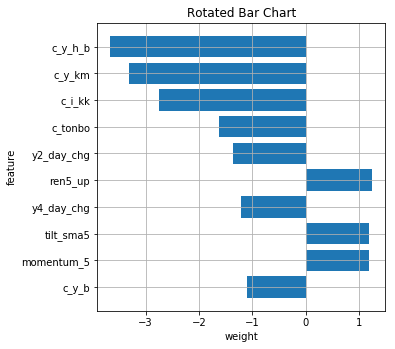



**▼ モデルの評価結果**

正答率（訓練データ） = 65.190%
正答率（テストデータ）= 55.414%
適合率（Precision※精度) = 58.182%
再現率（Recall※検出率) = 40.506%
F1値（F1-score） = 47.761%




**▼ 混同行列**

,予測 = 翌日上昇しない,予測 = 翌日上昇する
正解 = 翌日上昇しない,32,47
正解 =翌日上昇する,23,55




**▼ 閾値以上の信頼度でトレードした場合の勝率**

,pred,actual,max_prob
0,1,1,0.836492
1,1,1,0.707777
4,1,0,0.804022
5,1,1,0.888054
6,1,0,0.761672
9,1,1,0.771863
12,1,0,0.905395
13,1,0,0.790553
14,1,1,0.812222
15,1,1,0.877199


正答率（※閾値指定）=59.574%


In [9]:
# 学習
best_lr.fit(X_train, y_train)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_all_df.columns)
res_df['weight'] = np.reshape(best_lr.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
printmd('▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
printmd('▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(10, 5))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

y_train_pred = best_lr.predict(X_train) # 訓練データ
y_test_pred = best_lr.predict(X_test) # テストデータ


printmd('▼ モデルの評価結果')
print('正答率（訓練データ） = {:.3f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('正答率（テストデータ）= {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 翌日上昇しない', '正解 =翌日上昇する'], 
                        columns=['予測 = 翌日上昇しない', '予測 = 翌日上昇する'])
display(conf_mat)

printmd('▼ 閾値以上の信頼度でトレードした場合の勝率')
# 確率取得（上昇しない確率：上昇する確率）
prob = best_lr.predict_proba(X_test)

# 閾値を指定
max_prob, max_prob_args = [],[]
for i in range(len(prob)):
    max_prob.append(prob[i].max())
    if prob[i].max() > 0.70: # n%以上の確率データで絞る
        max_prob_args.append(prob[i].argmax())
    else:
        max_prob_args.append(-1)
a = pd.DataFrame(X_test)
a['pred'] = max_prob_args
a['actual'] = y_test
a['max_prob'] = max_prob
#b = a[a['pred'] != -1]
b = a[a['pred'] == 1] # 買いのみ実施した場合
display(b[['pred','actual','max_prob']].head(10))
print('正答率（※閾値指定）={:.3f}%'.format(accuracy_score(b['pred'], b['actual']) * 100))

# 翌日の予測

In [10]:
test_csv = X_today_df
test_csv['tomorrow_pred'] = best_lr.predict(X_today)
test_csv['prob0'] = best_lr.predict_proba(X_today)[:,0]
test_csv['prob1'] = best_lr.predict_proba(X_today)[:,1]
test_csv = test_csv.reset_index()
test_csv = test_csv[['time','open','high','low','close','tomorrow_pred','prob0','prob1']]
display(test_csv)

print('翌日上昇する確率 = {:.2f}%'.format(test_csv.iloc[0,7] * 100))
print('翌日下落する確率 = {:.2f}%'.format(test_csv.iloc[0,6] * 100))

,time,open,high,low,close,tomorrow_pred,prob0,prob1
0,2020-01-22,109.879,110.003,109.848,109.995,0,0.978186,0.021814


翌日上昇する確率 = 2.18%
翌日下落する確率 = 97.82%
